# Take Your First Step in Medical Image Classification #

**<font size="3">Artificial intelligence (AI) is getting importance day by day in healthcare. Again, Deep already shows its superhuman accuracy on image classification. So, AI enthusiasts are jumping to develop computer-aided detection systems to diagnose various diseases. Today, We will build a model to detect pediatric/child pneumonia. This kernel is for beginners who want to jump in medical image classification. We will pick a dataset containing pneumonia (bacterial and viral) and normal images. We will do binary (two-class) classification so our model will detect pneumonia from the test set. Data load and preprocessing, Training, and evaluation are basic steps of any classification model. We will follow these steps. There are various ways to preprocess any dataset. We want to do it an easy way so we think beginners can easily understand it. Beginners should follow the comments for better understading. If you don't understand anything or you have more queries, feel free to contact me. Email: sawrupkhan@yahoo.com</font>**

In [11]:
#import necessary libraries when needed
import os
import numpy as np
import pandas as pd
import pathlib
import imageio



# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**<font size="3">Now , We jump to get insight of the dataset.
Dataset has three folders (train , val ,test).</font>**


In [12]:
# Exploring dataset 
base_dir = '/Users/mac/Downloads/chest_xray/'

train_pneumonia_dir = base_dir+'train/PNEUMONIA/'
train_normal_dir=base_dir+'train/NORMAL/'

test_pneumonia_dir = base_dir+'test/PNEUMONIA/'
test_normal_dir = base_dir+'test/NORMAL/'

val_normal_dir= base_dir+'val/NORMAL/'
val_pnrumonia_dir= base_dir+'val/PNEUMONIA/'

train_pn = [train_pneumonia_dir+"{}".format(i) for i in os.listdir(train_pneumonia_dir) ]
train_normal = [train_normal_dir+"{}".format(i) for i in os.listdir(train_normal_dir) ]

test_normal = [test_normal_dir+"{}".format(i) for i in os.listdir(test_normal_dir)]
test_pn = [test_pneumonia_dir+"{}".format(i) for i in os.listdir(test_pneumonia_dir)]

val_pn= [val_pnrumonia_dir+"{}".format(i) for i in os.listdir(val_pnrumonia_dir) ]
val_normal= [val_normal_dir+"{}".format(i) for i in os.listdir(val_normal_dir) ]

print ("Total images:",len(train_pn+train_normal+test_normal+test_pn+val_pn+val_normal))
print ("Total pneumonia images:",len(train_pn+test_pn+val_pn))
print ("Total Nomral images:",len(train_normal+test_normal+val_normal))


Total images: 5856
Total pneumonia images: 4273
Total Nomral images: 1583


## Dataset Preprocessing & Visualization ## 
**<font size="3">The dataset is small. So, We follow 80%, 15%, 5% split. Besides, dataset is clearly imbalanced. We will take care of it later. </font>**

In [13]:
import os
import random
from sklearn.model_selection import train_test_split

# Gathering all pneumonia and normal images
pn = train_pn + test_pn + val_pn
normal = train_normal + test_normal + val_normal

# Ensure the same random split each time
random.seed(42)

# Splitting pneumonia and normal images into train, test, and validation
pn_train, pn_temp = train_test_split(pn, test_size=0.2, random_state=42)  # 80% train, 20% temp
pn_test, pn_val = train_test_split(pn_temp, test_size=0.25, random_state=42)  # 15% test, 5% val

normal_train, normal_temp = train_test_split(normal, test_size=0.2, random_state=42)
normal_test, normal_val = train_test_split(normal_temp, test_size=0.25, random_state=42)

# Combine pneumonia and normal images for each split
train_imgs = pn_train + normal_train
test_imgs = pn_test + normal_test
val_imgs = pn_val + normal_val

# Shuffling the combined lists
random.shuffle(train_imgs)
random.shuffle(test_imgs)
random.shuffle(val_imgs)

# Printing dataset sizes
print("Total Train Images %s containing %s pneumonia and %s normal images" 
      % (len(train_imgs), len(pn_train), len(normal_train)))
print("Total Test Images %s containing %s pneumonia and %s normal images" 
      % (len(test_imgs), len(pn_test), len(normal_test)))
print("Total Validation Images %s containing %s pneumonia and %s normal images" 
      % (len(val_imgs), len(pn_val), len(normal_val)))


Total Train Images 4684 containing 3418 pneumonia and 1266 normal images
Total Test Images 878 containing 641 pneumonia and 237 normal images
Total Validation Images 294 containing 214 pneumonia and 80 normal images


In [14]:
#showing a file name from test set
print(test_imgs[5])

/Users/mac/Downloads/chest_xray/train/PNEUMONIA/person905_bacteria_2830.jpeg


**<font size="3">Loading each image and their label into array</font>**

In [15]:
import os
import cv2
import numpy as np
from PIL import Image

img_size = 224

# Function to validate images
def validate_image(file_path):
    try:
        with Image.open(file_path) as img:
            img.verify()  # Verify that it's a valid image
        return True
    except Exception:
        return False

# Function to preprocess images
def preprocess_image(image_list):
    X = []  # Images
    y = []  # Labels (0 for Normal, 1 for Pneumonia)
    failed_images = []  # List to store failed image paths

    for image in image_list:
        try:
            # Validate image before processing
            if not validate_image(image):
                print(f"Invalid image: {image}")
                failed_images.append(image)
                continue

            img = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"Failed to load image: {image}")
                failed_images.append(image)
                continue

            # Resize the image
            img = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_CUBIC)

            # Convert grayscale image to 3D (RGB)
            img = np.dstack([img, img, img])

            # Convert to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Normalize image
            img = img.astype(np.float32) / 255.0

            # Append image to the list
            X.append(img)

            # Assign labels based on file name
            if 'NORMAL' in image:
                y.append(0)
            elif 'virus' in image or 'bacteria' in image:
                y.append(1)
            else:
                print(f"Could not determine label for image: {image}")
                failed_images.append(image)
                continue

        except Exception as e:
            print(f"Error processing image {image}: {e}")
            failed_images.append(image)
            continue

    return X, y

# Example paths to your dataset (adjust as per your actual paths)
train_pneumonia_dir =  base_dir+'train/PNEUMONIA/'
train_normal_dir = base_dir+'train/NORMAL/'

# Create a list of all image file paths in the directories
pn_images = [os.path.join(train_pneumonia_dir, f) for f in os.listdir(train_pneumonia_dir)]
normal_images = [os.path.join(train_normal_dir, f) for f in os.listdir(train_normal_dir)]

# Combine them into a single image list
image_list = pn_images + normal_images

# Process the images
X, y = preprocess_image(image_list)

# Check the number of processed images
print(f"Processed {len(X)} images.")
print(f"Labels: {y[:10]}")  # Displaying first 10 labels


Processed 5216 images.
Labels: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [16]:
from PIL import Image

def validate_image(file_path):
    try:
        with Image.open(file_path) as img:
            img.verify()  # Verify that it's a valid image
        return True
    except Exception:
        return False
image_list = [img for img in image_list if validate_image(img)]


In [17]:
# Check all the images getting labels or not
arr=y	
uniqueValues, occurCount = np.unique(arr, return_counts=True)
 
print("Unique Values : " , uniqueValues)
print("Occurrence Count : ", occurCount)


Unique Values :  [0 1]
Occurrence Count :  [1341 3875]


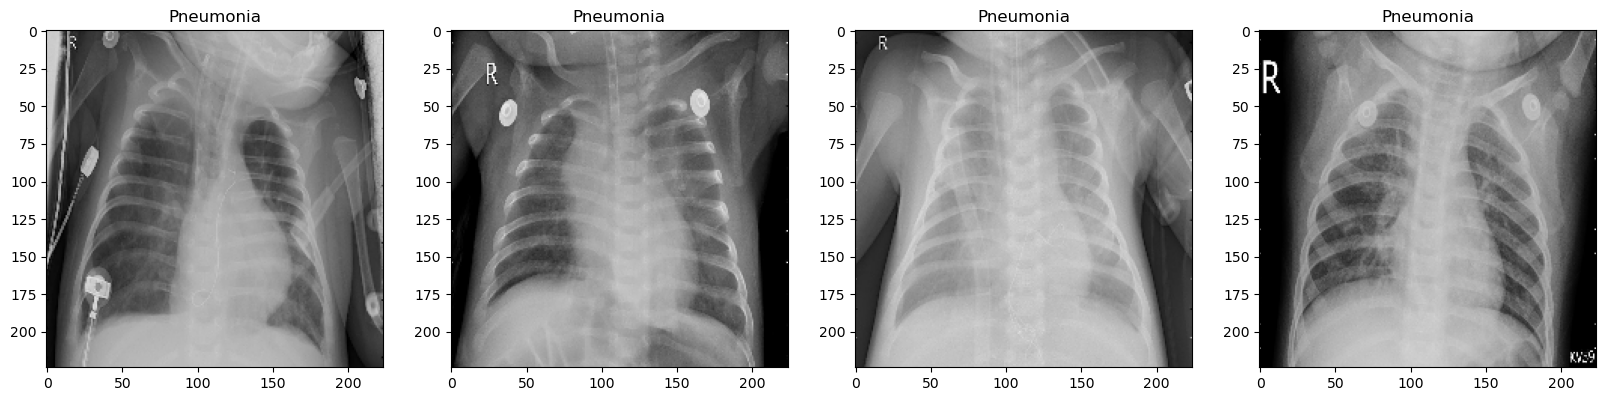

In [18]:
# Display some images from train set
# Feel free to show more image by changing the values

import matplotlib.pyplot as plt 

fig = plt.figure(figsize=(20, 5))
k=1
for i in range(4):
    a = fig.add_subplot(1, 4, k)
    if (y[i]==0):
        a.set_title('Normal')
    else:
        a.set_title('Pneumonia')
        
    plt.imshow(X[i])
    k=k+1;
    


In [19]:
# get the labels for test set

P, t = preprocess_image(test_imgs)

In [20]:
arr=t	
uniqueValues, occurCount = np.unique(arr, return_counts=True)
 
print("Unique Values : " , uniqueValues)
print("Occurrence Count : ", occurCount)

Unique Values :  [0 1]
Occurrence Count :  [237 641]


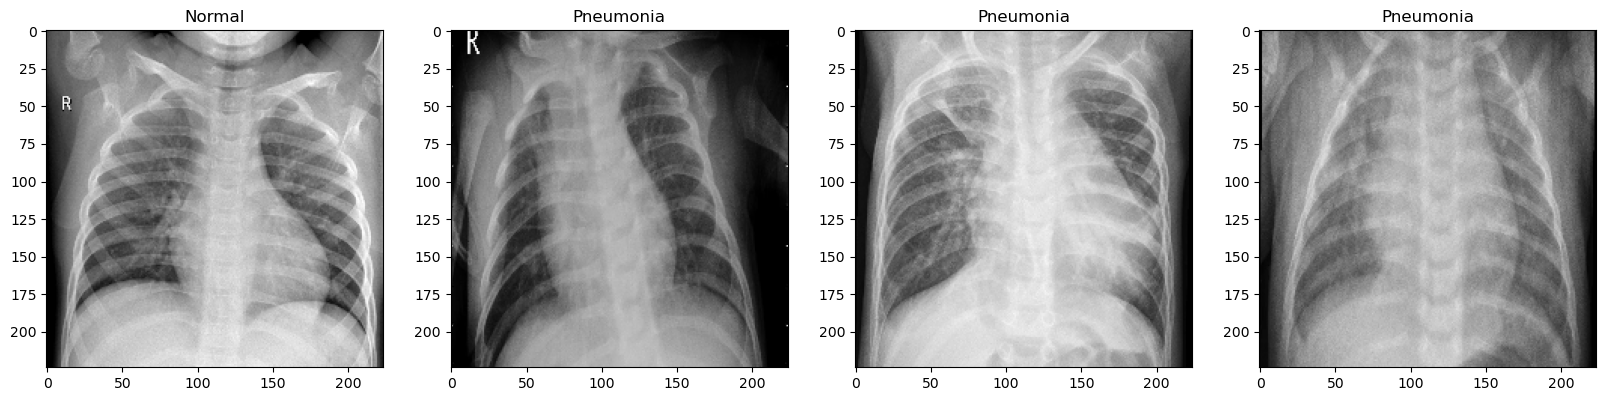

In [21]:
# now displaying some images from test set
# Feel free to show more image by changing the values

import matplotlib.pyplot as plt 

fig = plt.figure(figsize=(20, 5))
k=1
for i in range(4):
    a = fig.add_subplot(1, 4, k)
    if (t[i]==0):
        a.set_title('Normal')
    else:
        a.set_title('Pneumonia')
        
    plt.imshow(P[i])
    k=k+1;

In [22]:
# get the labels for validation set

K, m = preprocess_image(val_imgs)

In [23]:


arr=m

 
# Get a tuple of unique values & their frequency in numpy array
uniqueValues, occurCount = np.unique(arr, return_counts=True)
 
print("Unique Values : " , uniqueValues)
print("Occurrence Count : ", occurCount)

Unique Values :  [0 1]
Occurrence Count :  [ 80 214]


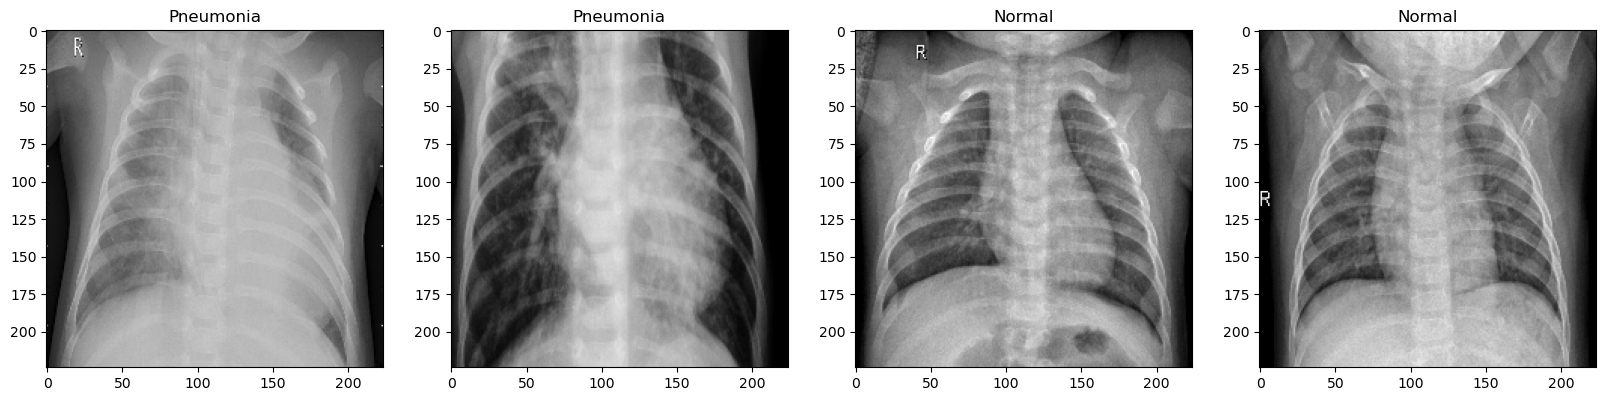

In [24]:
# now displaying some images from validation set
# Feel free to show more image by changing the values

import matplotlib.pyplot as plt 

fig = plt.figure(figsize=(20, 5))
k=1
for i in range(4):
    a = fig.add_subplot(1, 4, k)
    if (m[i]==0):
        a.set_title('Normal')
    else:
        a.set_title('Pneumonia')
        
    plt.imshow(K[i])
    k=k+1;

**<font size="4">Let's count and show the quantity of image in each set by counplot from Seaborn </font>**

/var/folders/nn/dfjvx0bn1t1f43mthz2cygdw0000gn/T/ipykernel_4159/2619545805.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


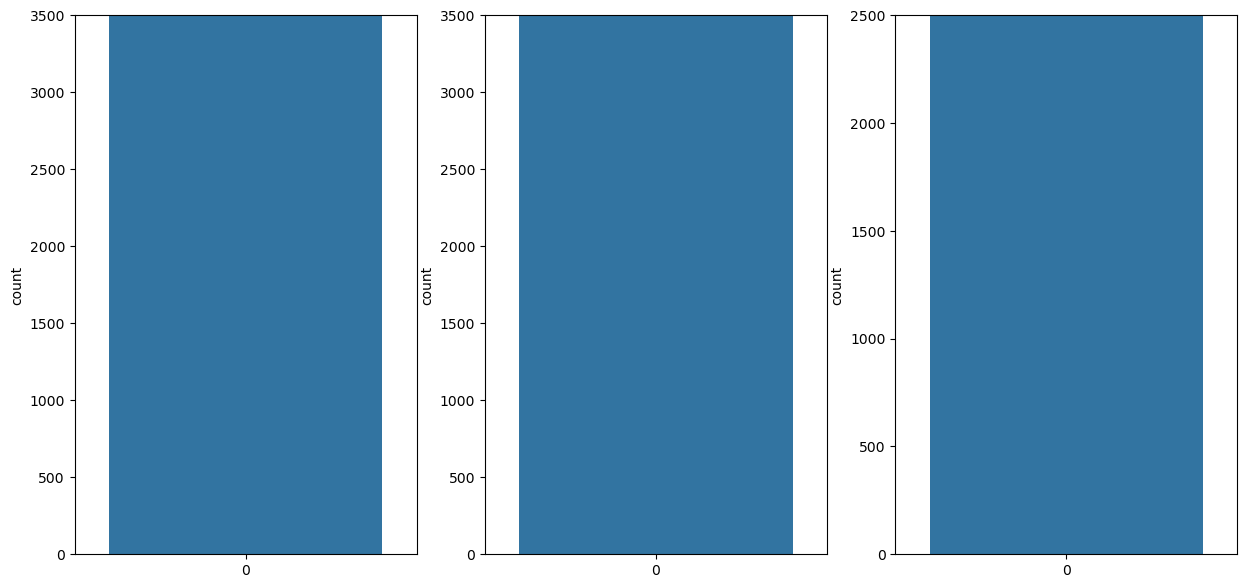

In [25]:
import seaborn as sns


df=pd.DataFrame()
df['Train']=y
df['Test']=pd.Series(t)
df['Val']=pd.Series(m)



fig, ax =plt.subplots(1,3,figsize=(15,7))
sns.countplot(df['Train'], ax=ax[0])
ax[0].set(ylim=(0, 3500))


sns.countplot(df['Test'], ax=ax[1])
ax[1].set(ylim=(0, 3500))

sns.countplot(df['Val'], ax=ax[2])
ax[2].set(ylim=(0, 2500))

fig.show()


## Dealing with class imbalance ##

**<font size="3">We can solve the class imbalance problem with several methods. One of the simplest ways to solve the class imbalance is to simply provide a weight for each class which places more emphasis on the minority classes so CNN model can learn equally from all classes. Here, we employ sklearn compute class weight function to set weight for each class. </font>**


In [26]:
from sklearn.utils import class_weight


class_weights = class_weight.compute_class_weight(
    class_weight='balanced',  # Specify 'balanced' or a dictionary
    classes=np.unique(y),          # Unique class labels
    y=y                       # Actual target labels
)

class_weights = dict(enumerate(class_weights))  # Convert to dictionary if needed
print(class_weights)

{0: 1.9448173005219984, 1: 0.6730322580645162}


In [27]:
import seaborn as sns
import gc

train_imgs = train_pn[:3875]+ train_normal[:1341]
del train_imgs
gc.collect()

X_train = np.array(X)
y_train = np.array(y)
X_test = np.array(P)
y_test = np.array(t)
X_val = np.array(K)
y_val = np.array(m)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)



(5216, 224, 224, 3)
(5216,)
(878, 224, 224, 3)
(878,)
(294, 224, 224, 3)
(294,)



<font size="6"> Training </font>




**<font size="3">We can say that training phase starts from here. We will use a batch size of 32. Batch size should be a power of 2 (4, 8, 16, 32, 64, 128, 256,....).
The batch size 32 means the model will train 32 training samples and then update its parameters once.
Batch training is faster and memory efficient.</font>**

In [28]:
# clear memory
del X
del y
gc.collect()

#get the length of the train and validation data
ntrain = len(X_train)
nval = len(X_val)

batch_size = 32

## Image Augmentation ##
**<font size="3">Lets build an input pipline for model with the augmentation technique.
We artificially increase the dataset with augmentation technique, since we are using a small dataset. 
It also helps prevent overfitting. Feel free to study various augmentation techniques in internet. </font>**

In [29]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=7,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.2,
    zoom_range=0.45,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(zoom_range=0.45)


2024-12-23 21:39:12.139158: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [30]:
#Create the image generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

In [31]:
# Set image Size
img_size =224

## Train full train set with MobileNet  ##

**<font size="3"> We don't build a convolutional neural network (CNN) architecture from scratch here. Instead, we use a pretrainted CNN architecture called MobileNet. </font>**

In [32]:
from keras import layers
from keras import models
from keras import optimizers
from keras.applications import *
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import img_to_array, load_img
from keras.models import Model
from keras import backend as K

# Create the base pre-trained model
# Weights should be none becuase we don't need to train with any pre-trained weights here

base_model = MobileNet(weights=None, include_top=False,input_shape=(img_size, img_size, 3)) 

x = base_model.output

# Add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# Add a logistic layer
predictions = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
# Compile model
model.compile(optimizer='adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])

In [40]:
# We can see details of  MobileNet architecure's details
# model.summary()

**<font size="3">Keep your GPU on or training time will be so high. Check your kaggle notebook's settings.**</font>

In [ ]:

# We train for 64 epochs 
history = model.fit(
    train_generator,
    steps_per_epoch=ntrain // batch_size,
    epochs=10,
    validation_data=val_generator,
    validation_steps=nval // batch_size,
    class_weight=class_weights,
)


**<font size="3">Plot how validation accuracy and loss are increasing  against training accuracy and loss.</font>**

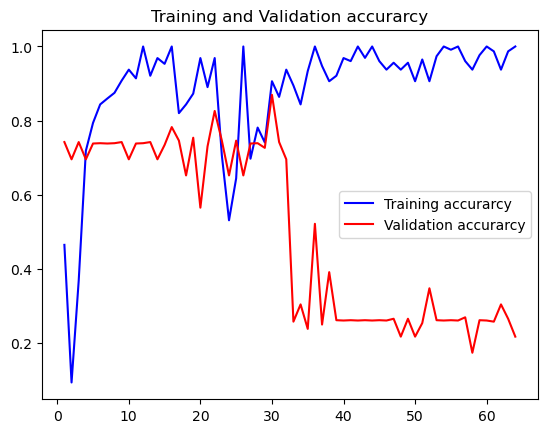

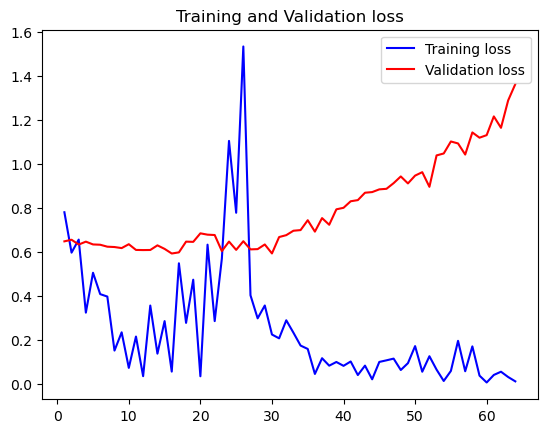

In [44]:
# Lets plot the train and val curve
# Get the details form the history object
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

## Estimation of classification performance / Result ##
**<font size="3">We will check our model classification ability using some evaluation matrices. It is very important to use multiple evaluation metrics to evaluate your model to ensure that the model is operating correctly and optimally. We will check our model's performance by Accuracy, Recall, Precision, F1 and AUC score. Feel free to search in google to know more about these matrices. </font>**

In [45]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(X_test)

acc = accuracy_score(y_test, np.round(preds))*100
cm = confusion_matrix(y_test, np.round(preds))

tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\n============TEST METRICS=============')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((history.history['binary_accuracy'][-1])*100, 2)))

12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 963ms/step
CONFUSION MATRIX ------------------
[[184   0]
 [186   0]]

============TEST METRICS=============
Accuracy: 49.72972972972973%
Precision: nan%
Recall: 0.0%
F1-score: nan

TRAIN METRIC ----------------------
Train acc: 100.0


/var/folders/nn/dfjvx0bn1t1f43mthz2cygdw0000gn/T/ipykernel_2270/2992945977.py:14: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp/(tp+fp)*100


<Axes: >

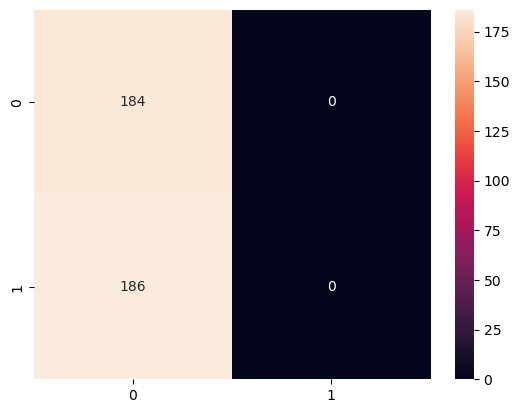

In [46]:
import seaborn as sns
sns.heatmap(cm, annot=True, fmt="d",)

**<font size="3">The ROC (receiver operating characteristic) curve indicates the diagnostic accuracy and porformance of a model.
We show the ROC curve and also calculate AUC score.</font>**

AUC Score: 0.4403780972417017


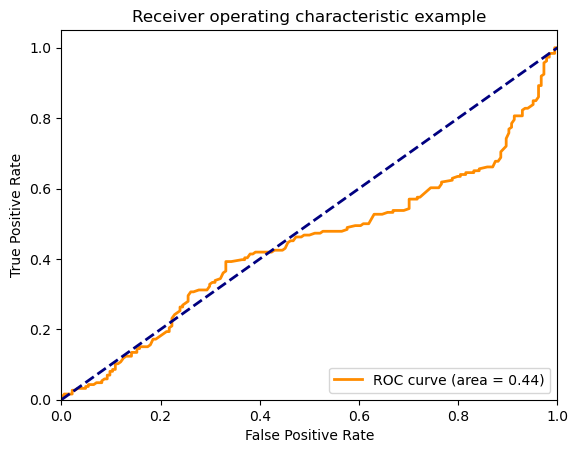

In [47]:
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import auc

fpr , tpr , thresholds = roc_curve ( y_test , preds)
auc_keras = auc(fpr, tpr)
print("AUC Score:",auc_keras)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_keras)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

**<font size="3">We see the model achieves great evaluation scores. It indicates that our model performs very well. But these scores can be increased. Beginners should apply different architectures. Transfer learning can be applied along with different augmentation techniques. If this kernel helps you, you can give an upvote. Stay tuned for more and Happy Coding !! </font>**